In [13]:
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

In [33]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs, nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()


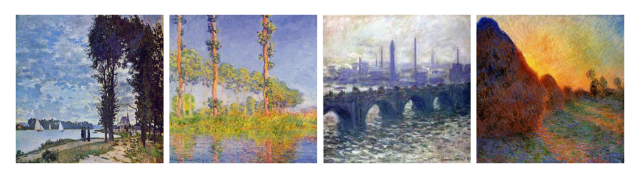

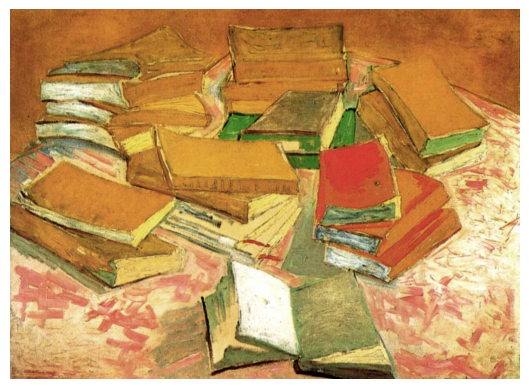

In [62]:
class Monet(Dataset):
    def __init__(self):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, self.img_names[index]))


class VanGogh(Dataset):
    def __init__(self):
        self.data_path = kagglehub.dataset_download(
            "ipythonx/van-gogh-paintings")
        self.df = pd.read_csv(os.path.join(self.data_path, "VanGoghPaintings.csv"))
        
        # only use folders containing painting images
        exclude = ["Drawings", "Sketches in letters", "Works of the young van Gogh"]
        mask = ~self.df["class_name"].isin(exclude)
        self.img_names = self.df[mask]["image_path"]
        
        # remove unused path prefix, replace with correct prefix
        self.img_names = self.img_names.apply(
            lambda x: x.replace("/kaggle/input/van-gogh-paintings/", "VincentVanGogh/"))
        
        # TODO - resize images to lower resolution, and maybe to square??

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.data_path, self.img_names[index]))


monet_loader = DataLoader(Monet(), batch_size=4, shuffle=True)
show_images(next(iter(monet_loader)))

van_gogh_loader = DataLoader(VanGogh(), batch_size=1, shuffle=True)
show_images(next(iter(van_gogh_loader)))